# 3D Reconstruction
Now that we have the silhuettes we can now extract the visual hull of the object. Do so we need the camera intrinsic parameters and the extrinsic paramters. Our simulation pipeline already provides us with a json file for that. A python script then can be ran to extract the camera intrinsics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.camera_data import CamerasData
from src.scans import Scans
from src.convex_hull import project_scan

## 1. Data Classes
To do the reconstruction we need to organize our data into clear but usefull classes. This will include our Camera Data (`CameraData`) and our Pictures (`Scans`)

### 1.1. Camera Data
For the reconstruction we need:
- Camera Intrinsics
- Extrinsics Parameters

The camera intrinsics are defined by the matrix K and the extrinsics are defined by the individual camera positions (4x4 matrix). All of this is managed by the class ```CameraData```

In [2]:
camera_data = CamerasData("../blender_simulator/simulated_frames/dataset_d30/camera_intrinsics.json", "../blender_simulator/simulated_frames/dataset_d30/transforms_train.json")

In [3]:
print(f"K Matrix:\n{camera_data.K}\n")
print(f'Extrinsic Matrix of Camera 0\n{camera_data.get_camera_extrinsics(0)}\n')
print(f'With shape: {camera_data.extrinsics_array.shape}')

K Matrix:
[[2.66666667e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 2.25000000e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extrinsic Matrix of Camera 0
[[ 9.99992847e-01  3.79740074e-03 -3.63797881e-12  3.79740074e-03]
 [ 5.45056282e-05 -1.43533014e-02  9.99897003e-01 -1.43533014e-02]
 [ 3.79700959e-03 -9.99889851e-01 -1.43534066e-02 -9.99889851e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

With shape: (12, 4, 4)


**Projection Matrix**<br>
By combining both matrices we can have the projection matrix

In [4]:
P = camera_data.P(0)

print(f'Projection Matyrix of Camera 0\n{P}\n')
print(f'With shape: {P.shape}')

Projection Matyrix of Camera 0
[[ 2.67029272e+03 -9.49767855e+02 -1.37792704e+01 -9.49767855e+02]
 [ 2.17302284e+00 -5.72235447e+02  2.24201742e+03 -5.72235447e+02]
 [ 3.79700959e-03 -9.99889851e-01 -1.43534066e-02 -9.99889851e-01]]

With shape: (3, 4)


### 1.2 Scans
Scans should have all the segemntations from the pictures taken. It holds the data as a binary array [0 or 1]

In [5]:
scans = Scans("../3d_reconstruction/figures/reconstruction_d30/segmented")

Number of scans: 12
Dimension of each scan: (1080, 1920)
Values in the first scan: [0 1]


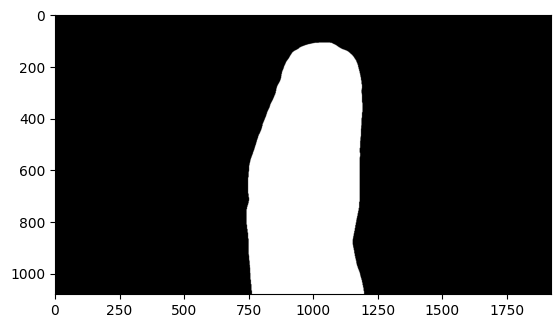

In [6]:
print(f"Number of scans: {scans.nr_positions}")
print(f"Dimension of each scan: {scans.scan_shape}")
print(f"Values in the first scan: {np.unique(scans.scan(0))}")

plt.imshow(scans.scan(0), cmap='gray')

## 2. Convex Hull
This will take the data and apply the convex hull algorithm

In [7]:
example_camera = 1

### 2.1. Projecting Single Point
Before we compute any reconstruction we should just test projecting some points (like origin) to check if the matrices are ok. In this process it was found that the `transformation_matrix` produced by **BlenderNeRF** was not world to camera but rather camera to world. This is fixed now when the camera data is initialized  

Projecting 3D Point: [0 0 0]

Projection Coordinates X1 : -986.0, X2 : -572.0, X3 : -1.0
Image Coordinates (np.float64(986.0), np.float64(572.0))


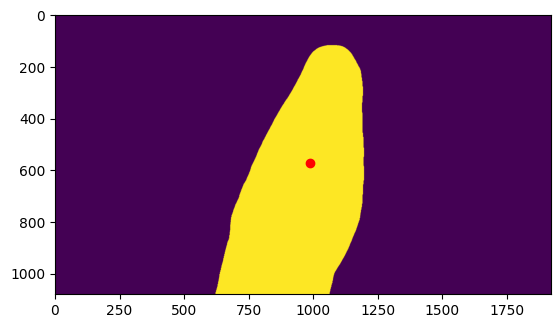

In [8]:
P = camera_data.P(example_camera)
point_3d = np.array([0,0,0,1])
print(f"Projecting 3D Point: {point_3d[:3]}\n")

# Projecting
x1, x2, x3 = P @ point_3d
print(f"Projection Coordinates X1 : {np.round(x1)}, X2 : {np.round(x2)}, X3 : {np.round(x3)}")
print(f"Image Coordinates {np.round(x1/x3), np.round(x2/x3)}")

# Plotting
plt.imshow(scans.scan(example_camera))
plt.scatter(x1//x3, x2/x3, color='red')

### 2.2. Obtaining Single Convex Hull
Let's see if we can map a grid of points in other to build the first building block in the reconstruction pipeline

🔄 Processing Slices: 100%|██████████| 200/200 [00:13<00:00, 15.28it/s]

Voxel Size: 0.005 m with Volume: 126.894 mm³ per Voxel


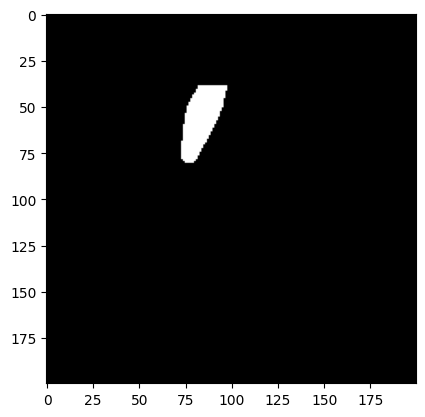

In [10]:
camera_volume, voxel_size = project_scan(camera_data, scans, example_camera, resolution=200, reconstruction_range=0.5)

print(f"Voxel Size: {np.round(voxel_size,3)} m with Volume: {np.round(voxel_size**3 * 1e9, 3)} mm³ per Voxel")

plt.imshow(camera_volume[:, 0, :], cmap='gray')